In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
from arnie.mea.mea import MEA
from arnie.bpps import bpps
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from functools import partial
from tqdm import tqdm

In [2]:
train = pd.read_json("data/train.json", lines=True)
test = pd.read_json("data/test.json", lines=True)

In [3]:
sequences = train.sequence.tolist() + test.sequence.tolist()
seq_ids = train.id.tolist() + test.id.tolist()
structures = train.structure.tolist() + test.structure.tolist()
predicted_loop_types = train.predicted_loop_type.tolist() + test.predicted_loop_type.tolist()

In [4]:
Path("data/vienna_2/bpps").mkdir(exist_ok=True, parents=True)
Path("data/nupack_95/bpps").mkdir(exist_ok=True, parents=True)
Path("data/nupack_99/bpps").mkdir(exist_ok=True, parents=True)

In [18]:
def get_save_bpps(sequence, seq_id, pkg, T):
    mat = bpps(sequence, T=T, package=pkg)
    np.save(f"data/{pkg}/bpps/{seq_id}_{T}.npy", mat)

In [19]:
%%time
get_save_bpps(train.sequence.iloc[0], train.id.iloc[0], 'vienna_2', 50)

CPU times: user 8.32 ms, sys: 4.68 ms, total: 13 ms
Wall time: 54.5 ms


In [20]:
%%time
for T in [7, 17, 27, 47, 57, 67]:
    for (seq, idx) in tqdm(zip(sequences, seq_ids)):
        get_save_bpps(seq, idx, "vienna_2", T)

6034it [03:24, 29.58it/s]
6034it [03:23, 29.65it/s]
6034it [03:24, 29.46it/s]
6034it [03:47, 26.58it/s]
6034it [03:28, 28.92it/s]
6034it [03:32, 28.41it/s]

CPU times: user 1min 44s, sys: 2min 58s, total: 4min 43s
Wall time: 21min


In [21]:
for T in [7, 17, 27, 37, 47, 57, 67]:
    Parallel(8)(delayed(get_save_bpps)(seq, idx, "nupack_95", T) for (seq, idx) in tqdm(zip(sequences, seq_ids)))

6034it [05:50, 17.23it/s]
6034it [05:51, 17.15it/s]
6034it [05:57, 16.89it/s]
6034it [05:58, 16.83it/s]
6034it [06:03, 16.59it/s]
6034it [05:59, 16.78it/s]
6034it [05:59, 16.79it/s]


In [10]:
for T in [37]:
    Parallel(8)(delayed(get_save_bpps)(seq, idx, "nupack_99", T) for (seq, idx) in tqdm(zip(sequences, seq_ids)))

6034it [04:25, 22.72it/s]


In [7]:
from arnie.mfe import mfe
def get_mfe_structures(seq, T=37):
    return mfe(seq, T=T)

In [51]:
structures = {}
for T in [7, 17, 27, 47, 57, 67]:
    res = Parallel(8)(delayed(get_mfe_structures)(seq, T) for seq in tqdm(sequences))
    structures[T] = res

100%|██████████| 6034/6034 [00:24<00:00, 244.52it/s]


In [65]:
vienna_structs = pd.DataFrame(structures)
vienna_structs.columns = [f"vienna_{tt}" for tt in [7, 17, 27, 47, 57, 67]]
vienna_structs["id"] = seq_ids
vienna_structs.head()

,vienna_7,vienna_17,vienna_27,vienna_47,vienna_57,vienna_67,id
0,.......((((.......)))).((((((........))))))......,.......((((.......)))).((((((........))))))......,.....((((((.......)))).)).((.....((..((((((......,.....((((((.......)))).)).((.....((..((((((......,................(((....((((((........))))))......,......................................(((((......,id_001f94081
1,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,id_0049f53ba
2,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,........................((((...((..((((......)...,.....................(..((((...((..((((......)...,id_006f36f57
3,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......(((((((((((((((((......)))))))))))))))))...,......(((((((((((((((((......)))))))))))))))))...,id_0082d463b
4,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,......(((((((((((((((((...............))))))))...,......(((((((((((((((((...............))))))))...,id_0087940f4


In [71]:
vienna_structs.to_csv("data/vienna_sructures_mec.csv", index=False)

In [4]:
import subprocess

In [37]:
!perl bpRNA/bpRNA.pl id_0049f53ba.dbn

In [6]:
%%time
proc = subprocess.Popen(['perl', 'bpRNA/bpRNA.pl', 'id_0049f53ba.dbn'])
proc.wait()

CPU times: user 0 ns, sys: 7.41 ms, total: 7.41 ms
Wall time: 200 ms


0

In [12]:
import subprocess

def map_segs(result, seq_len=107):
    seg_num = [-1] * seq_len
    seg_pairs = [0] * seq_len
    pl_segs = [0] * seq_len
    for linenum, line in enumerate(result):
        if linenum <= 6:
            continue
        if line.startswith("segment"):
            tokens = line.split(" ")
            num = int(tokens[0].strip("segment"))
            num_pairs = int(tokens[1].strip("bp"))
            i_1, _, i_2 = tokens[2].split(".")
            j_1, _, j_2 = tokens[4].split(".")
            i_1, i_2 = int(i_1), int(i_2)
            j_1, j_2 = int(j_1), int(j_2)
            for i in range(i_1, i_2+1):
                seg_num[i-1] = num
                seg_pairs[i-1] = num_pairs

            for j in range(j_1, j_2):
                seg_num[j-1] = num
                seg_pairs[j-1] = num_pairs

        elif line.startswith("S"):
            tokens = line.split(" ")
            num = int(tokens[0].strip("S"))
            i_1, _, i_2 = tokens[1].split(".")
            j_1, _, j_2 = tokens[3].split(".")
            i_1, i_2 = int(i_1), int(i_2)
            j_1, j_2 = int(j_1), int(j_2)
            for i in range(i_1, i_2+1):
                pl_segs[i-1] = f"S{num}"
            for j in range(i_1, i_2+1):
                pl_segs[j-1] = f"S{num}"
        else:
            tokens = line.split(" ")
            sym = tokens[0][0]
            num = tokens[0].strip("BSHIMXE").split(".")
            if len(num) > 1:
                num = int(num[0]) * int(num[1]) + int(num[0]) - 1
            else:
                num = int(num[0])
            i_1, _, i_2 = tokens[1].split(".")
            i_1, i_2 = int(i_1), int(i_2)
            for i in range(i_1, i_2+1):
                pl_segs[i-1] = f"{sym}{num}"
        
    return seg_num, seg_pairs, pl_segs


def predict_loop(seq, struct, seq_id):
    seq_len = len(seq)
    subprocess.run(f"echo {seq} > {seq_id}.dbn", shell=True)
    subprocess.run(f"echo '{struct}' >> {seq_id}.dbn", shell=True)
    proc = subprocess.Popen(['perl', 'bpRNA/bpRNA.pl', f'{seq_id}.dbn'])
    proc.wait()
    with open(f"{seq_id}.st") as stf:
        result = [l.strip('\n') for l in stf]
    pl = result[5]
    subprocess.run(f"rm {seq_id}.dbn {seq_id}.st", shell=True)
    seg_num, seg_pairs, pl_segs = map_segs(result, seq_len)
    
    #segments = [row  for row in result if row.startswith('segment')]
    #num_seg, num_bp = len(segments), sum([int(seg.split(" ")[1].strip("bp")) for seg in segments])    
    return seq_id, pl, "_".join([str(c) for c in seg_num]), "_".join([str(c) for c in seg_pairs]), "_".join([str(c) for c in pl_segs])

In [13]:
seq_ids = train.id.tolist() + test.id.tolist()
sequences = train.sequence.tolist() + test.sequence.tolist()
structures = train.structure.tolist() + test.structure.tolist()
res = Parallel(16)(delayed(predict_loop)(seq, struc, seqid) for seq, struc, seqid in tqdm(zip(sequences, structures, seq_ids)))
# res = []
# for seq, struc, seq_id in tqdm(zip(sequences[:10], structures[:10], seq_ids[:10])):
#     res.append(predict_loop(seq, struc, seq_id))
res = pd.DataFrame(res, columns=["id", "pstructure", "bp_seg_num", "bp_seg_pairs", "pl_seg_num"])
res.to_csv("data/predicted_loop_segments.csv", index=False)

6034it [02:26, 41.07it/s]


In [14]:
res.head()

,id,pstructure,bp_seg_num,bp_seg_pairs,pl_seg_num
0,id_001f94081,EEEEESSSSSSHHHHHHHSSSSBSSMSSIIIIISSIISSSSSSHHH...,-1_-1_-1_-1_-1_1_1_1_1_1_1_-1_-1_-1_-1_-1_-1_-...,0_0_0_0_0_6_6_6_6_6_6_0_0_0_0_0_0_0_6_6_6_6_6_...,E1_E1_E1_E1_E1_S1_S1_S2_S2_S2_S2_H1_H1_H1_H1_H...
1,id_0049f53ba,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_23_23_23_23_23_23_23_23_23_23_23_23_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S...
2,id_006f36f57,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_10_10_10_10_10_10_10_10_10_10_10_10_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_I1_S2_S2_I3_I3_I3_I...
3,id_0082d463b,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,-1_-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,0_0_0_0_0_0_16_16_16_16_16_16_16_16_16_16_16_1...,E1_E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S...
4,id_0087940f4,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_28_28_28_28_28_28_28_28_28_28_28_28_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_B1_S2_S2_S...


In [11]:
import numpy as np
bbbb = res.bp_seg_num.iloc[0]
bp_seg_num = bbbb.split("_")
bseg, idx = np.unique(bp_seg_num, return_inverse=True)
bseg, idx

(array(['-1', '1', '2', '3'], dtype='<U2'),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
        0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [16]:
segment = res.pl_seg_num.iloc[0].split("_")
segment

['E1',
 'E1',
 'E1',
 'E1',
 'E1',
 'S1',
 'S1',
 'S2',
 'S2',
 'S2',
 'S2',
 'H1',
 'H1',
 'H1',
 'H1',
 'H1',
 'H1',
 'H1',
 '0',
 '0',
 '0',
 '0',
 'B1',
 '0',
 '0',
 'M1',
 'S3',
 'S3',
 'I1',
 'I1',
 'I1',
 'I1',
 'I1',
 'S4',
 'S4',
 'I3',
 'I3',
 'S5',
 'S5',
 'S5',
 'S5',
 'S5',
 'S5',
 'H2',
 'H2',
 'H2',
 'H2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'I5',
 'I5',
 '0',
 '0',
 'I2',
 'I2',
 'I2',
 'I2',
 'I2',
 '0',
 '0',
 'M2',
 'M2',
 'M2',
 'M2',
 'S6',
 'S6',
 'S6',
 'S6',
 'S6',
 'S6',
 'S6',
 'H3',
 'H3',
 'H3',
 'H3',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2',
 'E2']

In [17]:
segs, seg_idx, seg_rev_idx = np.unique(segment, return_index=True, return_inverse=True)
segs, seg_idx, seg_rev_idx

(array(['0', 'B1', 'E1', 'E2', 'H1', 'H2', 'H3', 'I1', 'I2', 'I3', 'I5',
        'M1', 'M2', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'], dtype='<U2'),
 array([18, 22,  0, 86, 11, 43, 75, 28, 57, 35, 53, 25, 64,  5,  7, 26, 33,
        37, 68]),
 array([ 2,  2,  2,  2,  2, 13, 13, 14, 14, 14, 14,  4,  4,  4,  4,  4,  4,
         4,  0,  0,  0,  0,  1,  0,  0, 11, 15, 15,  7,  7,  7,  7,  7, 16,
        16,  9,  9, 17, 17, 17, 17, 17, 17,  5,  5,  5,  5,  0,  0,  0,  0,
         0,  0, 10, 10,  0,  0,  8,  8,  8,  8,  8,  0,  0, 12, 12, 12, 12,
        18, 18, 18, 18, 18, 18, 18,  6,  6,  6,  6,  0,  0,  0,  0,  0,  0,
         0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3]))

In [10]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [4]:
res = pd.read_csv("data/predicted_loop_segments.csv")
res.head()

,id,pstructure,bp_seg_num,bp_seg_pairs,pl_seg_num
0,id_001f94081,EEEEESSSSSSHHHHHHHSSSSBSSMSSIIIIISSIISSSSSSHHH...,-1_-1_-1_-1_-1_1_1_1_1_1_1_-1_-1_-1_-1_-1_-1_-...,0_0_0_0_0_6_6_6_6_6_6_0_0_0_0_0_0_0_6_6_6_6_6_...,E1_E1_E1_E1_E1_S1_S1_S2_S2_S2_S2_H1_H1_H1_H1_H...
1,id_0049f53ba,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_23_23_23_23_23_23_23_23_23_23_23_23_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S...
2,id_006f36f57,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_10_10_10_10_10_10_10_10_10_10_10_10_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_I1_S2_S2_I3_I3_I3_I...
3,id_0082d463b,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,-1_-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,0_0_0_0_0_0_16_16_16_16_16_16_16_16_16_16_16_1...,E1_E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_S1_S1_S...
4,id_0087940f4,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,-1_-1_-1_-1_-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1...,0_0_0_0_0_28_28_28_28_28_28_28_28_28_28_28_28_...,E1_E1_E1_E1_E1_S1_S1_S1_S1_S1_S1_S1_B1_S2_S2_S...


In [5]:
from pytorch_geometric_dataset import preprare_graph
index = 3000
seqid = seq_ids[index]
sequence = sequences[index]
structure = structures[index]
predicted_loop_type = predicted_loop_types[index]
bpps = np.load(f"data/bpps/{seqid}.npy")
segment_bp = res.bp_seg_num.iloc[index]
segment_bp_pairs = res.bp_seg_pairs.iloc[index]
segment_pl = res.pl_seg_num.iloc[index]

data = preprare_graph(sequence, structure, predicted_loop_type, bpps, segment_bp, segment_bp_pairs, segment_pl)

In [6]:
from torch_geometric.utils.convert import to_networkx
graph = to_networkx(data)
node_labels = np.array(range(data.num_nodes))

In [7]:
data.num_nodes

135

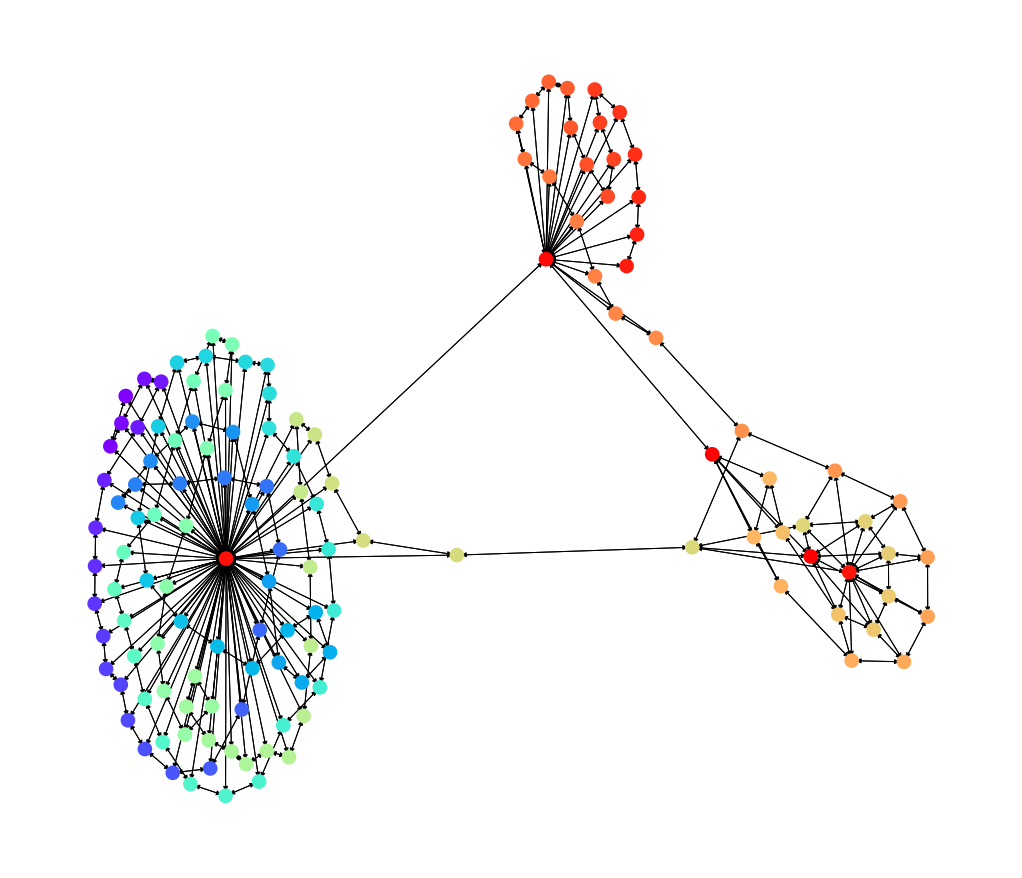

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(1,figsize=(14,12)) 
nx.draw(graph, cmap=plt.get_cmap('rainbow'),node_color = node_labels,node_size=75,linewidths=6)
plt.show()

In [39]:
get_segment_neighors(segment)

NameError: name 'get_segment_neighors' is not defined

In [9]:
vienna_structs = pd.read_csv("data/vienna_sructures_mec.csv")
vienna_structs.head()

,vienna_7,vienna_17,vienna_27,vienna_47,vienna_57,vienna_67,id
0,.......((((.......)))).((((((........))))))......,.......((((.......)))).((((((........))))))......,.....((((((.......)))).)).((.....((..((((((......,.....((((((.......)))).)).((.....((..((((((......,................(((....((((((........))))))......,......................................(((((......,id_001f94081
1,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,.....(((((((((((((((((((((((....)))))))))).)))...,id_0049f53ba
2,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,.....((((.((.....((((.(((.....)))..((((......)...,........................((((...((..((((......)...,.....................(..((((...((..((((......)...,id_006f36f57
3,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......((((((((((((((((......))))))))))))))))((...,......(((((((((((((((((......)))))))))))))))))...,......(((((((((((((((((......)))))))))))))))))...,id_0082d463b
4,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,.....(((((((.((((((((((((.(((((((((....)))))))...,......(((((((((((((((((...............))))))))...,......(((((((((((((((((...............))))))))...,id_0087940f4


In [22]:
train.structure.iloc[101], vienna_structs.vienna_47.iloc[101]

('................(((((.((....((((.((((....))))..))))....))..)))))....(((((((....))))))).....................',
 '................(((((.((....((((.((((....))))..))))....))..)))))....(((((((....))))))).....................')

In [11]:
sequence = sequences[1]
structure = vienna_structs.vienna_17.iloc[1]
seqid = seq_ids[1]
predict_loop(sequence, structure, seqid)

'EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSSSSSSSSSSSSXXSSSHHHSSSXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE'

In [5]:
import numpy as np
seq_id = "id_001f94081"
b1 = [np.load(f"data/bpps/{seq_id}.npy").astype("float32")]
b2 = [np.load(f"data/vienna_2/bpps/{seq_id}_{T}.npy").astype("float32") for T in [7, 17, 27, 47, 57, 67]]
b =b1 + b2
np.dstack(b).shape

(107, 107, 7)

In [12]:
vienna_pl = {}
for T in [7, 17, 27, 47, 57, 67]:
    structures = vienna_structs[f"vienna_{T}"].tolist()
    res = Parallel(16)(delayed(predict_loop)(seq, struc, seqid) for seq, struc, seqid in tqdm(zip(sequences, structures, seq_ids)))
    #res = []
    #for seq, struc in tqdm(zip(sequences[:10], structures[:10])):
    #    res.append(predict_loop(seq, struc))
    res = np.array(res)
    vienna_structs[f"vienna_{T}_pl"]= res

6034it [02:20, 42.90it/s]
6034it [02:17, 43.96it/s]
6034it [02:16, 44.08it/s]
6034it [02:24, 41.69it/s]
6034it [02:28, 40.75it/s]
6034it [02:28, 40.71it/s]


In [13]:
vienna_structs[["vienna_67", "vienna_67_pl"]]

,vienna_67,vienna_67_pl
0,......................................(((((......,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEESSSSSHHH...
1,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...
2,.....................(..((((...((..((((......)...,EEEEEEEEEEEEEEEEEEEEESIISSSSIIISSIISSSSHHHHHHS...
3,......(((((((((((((((((......)))))))))))))))))...,EEEEEESSSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSS...
4,......(((((((((((((((((...............))))))))...,EEEEEESSSSSSSSSSSSSSSSSHHHHHHHHHHHHHHHSSSSSSSS...
...,...,...
6029,........(((((.....((((...((((((......))))))......,EEEEEEEESSSSSMMMMMSSSSIIISSSSSSHHHHHHSSSSSSIII...
6030,.......(((((...(((..........))).......(((........,EEEEEEESSSSSMMMSSSHHHHHHHHHHSSSMMMMMMMSSSHHHHH...
6031,.....(((((((....)))))))(((.(((((((((((((((((((...,EEEEESSSSSSSHHHHSSSSSSSSSSBSSSSSSSSSSSSSSSSSSS...
6032,...............................((((((............,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEESSSSSSIIIIIIIII...


In [15]:
def prepare_T_df(df, seq_ids, sequences, T, pkg="vienna", ptype="mec"):
    tmp = df[[f"vienna_{T}", f"vienna_{T}_pl"]]
    tmp.columns = ["structure", "predicted_loop_type"]
    tmp["id"] = seq_ids
    tmp["sequence"] = sequences
    print(tmp.head())
    tmp.to_csv(f"data/{pkg}_{T}_{ptype}.csv")

In [18]:
for T in [7, 17, 27, 47, 57, 67]:
    prepare_T_df(vienna_structs, seq_ids, sequences, T, "vienna", "mec")

<ipython-input-15-96598a6470ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["id"] = seq_ids
<ipython-input-15-96598a6470ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["sequence"] = sequences
<ipython-input-15-96598a6470ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

                                           structure  \
0  .......((((.......)))).((((((........))))))......   
1  .....(((((((((((((((((((((((....)))))))))).)))...   
2  .....((((.((.....((((.(((.....)))..((((......)...   
3  ......((((((((((((((((......))))))))))))))))((...   
4  .....(((((((.((((((((((((.(((((((((....)))))))...   

                                 predicted_loop_type            id  \
0  EEEEEEESSSSHHHHHHHSSSSXSSSSSSHHHHHHHHSSSSSSXXX...  id_001f94081   
1  EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...  id_0049f53ba   
2  EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...  id_006f36f57   
3  EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...  id_0082d463b   
4  EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...  id_0087940f4   

                                            sequence  
0  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...  
1  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...  
2  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...  
3  GGAAAAGCGCGCGCGCGCG

<ipython-input-15-96598a6470ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["id"] = seq_ids
<ipython-input-15-96598a6470ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["sequence"] = sequences
<ipython-input-15-96598a6470ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [4]:
from arnie.free_energy import free_energy
def get_free_energy(seq, T):
    e1 = free_energy(seq, T=T, package="vienna_2")
    e2 = free_energy(seq, T=T, package="nupack_95")
    return e1, e2

In [12]:
energies = {}
for T in [7, 17, 27, 47, 57, 67]:
    res = Parallel(8)(delayed(get_free_energy)(seq, T) for seq in tqdm(sequences))
    energies[f"vienna_{T}"], energies[f"nupack_{T}"] = np.array(res)[:, 0], np.array(res)[:, 1]

100%|██████████| 6034/6034 [03:05<00:00, 32.47it/s]


In [15]:
energy_df = pd.DataFrame(energies)
energy_df["id"] = seq_ids
energy_df.head()

,vienna_7,nupack_7,vienna_17,nupack_17,vienna_27,nupack_27,vienna_47,nupack_47,vienna_57,nupack_57,vienna_67,nupack_67,id
0,-38.60,-45.773811,-32.27,-37.874444,-26.20,-30.553592,-15.10,-17.888217,-10.57,-12.727315,-7.12,-8.337321,id_001f94081
1,-90.79,-86.791179,-80.98,-77.293064,-71.34,-68.207517,-52.80,-50.920675,-44.05,-42.740304,-35.65,-34.961582,id_0049f53ba
2,-37.14,-46.443992,-31.16,-37.956509,-25.48,-30.172993,-15.19,-17.920684,-10.88,-12.976750,-7.43,-8.714225,id_006f36f57
3,-90.77,-86.806197,-81.32,-77.988305,-71.98,-69.381008,-53.73,-52.645032,-44.86,-44.477025,-36.28,-36.488940,id_0082d463b
4,-40.30,-40.733947,-33.43,-33.245114,-26.69,-26.067160,-14.05,-14.030343,-8.84,-9.225091,-4.82,-5.258081,id_0087940f4


In [16]:
energy_df.to_csv("data/free_energies.csv", index=False)

In [18]:
def predict_MEA_structures(matrix_list, gamma_min=-6, gamma_max=6):
    matrices = [np.load(x) for x in matrix_list]
    seq_id = [Path(x).stem for x in matrix_list]
    gamma_vals = [x for x in range(gamma_min, gamma_max, 2)]
    structures = {}
    struct_scores = {}
    for sid, matrix in tqdm(zip(seq_id, matrices)):
        row_metrics = []
        row_structure = []
        for g in gamma_vals:
            mea_cls = MEA(matrix, gamma=2**g)
            metrics = mea_cls.score_expected() #sen, ppv, mcc, fscore
            row_metrics.append(metrics)
            row_structure.append(mea_cls.structure)
        struct_scores[sid] = row_metrics
        structures[sid] = row_structure
    return structures, struct_scores

In [6]:
train = pd.read_json("data/train.json", lines=True)

In [10]:
np.load("data/bpps/id_00073f8be.npy")

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00046446],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00017785],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00046446, 0.00017785, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
matrix_list = [f"data/bpps/{sid}.npy" for sid in train.id.tolist()]
structures, scores = predict_MEA_structures(matrix_list)

755it [45:06,  3.36s/it]

In [ ]:
with open("data/additional_structures.json", "w") as f:
    json.dump(structures, f)
    
with open("data/additional_structure_scores.json", "w") as f:
    json.dump(scores, f)

In [ ]:
test = pd.read_json("data/test.json", lines=True)
matrix_list = [f"data/bpps/{sid}.npy" for sid in test.id.tolist()]
structures, scores = predict_MEA_structures(matrix_list)
with open("data/additional_structures_test.json", "w") as f:
    json.dump(structures, f)
    
with open("data/additional_structure_scores_test.json", "w") as f:
    json.dump(scores, f)

In [2]:
import torch
from torch_geometric.data import Data

ModuleNotFoundError: No module named 'torch_sparse'

In [4]:
import torch
from torch import nn

In [109]:
a = torch.rand(2, 10, 64)
a.shape

torch.Size([2, 10, 64])

In [110]:
c = nn.Conv1d(10, 20, stride=1, kernel_size=9, padding=4)

In [111]:
d = c(a)
d.shape

torch.Size([2, 20, 64])

In [104]:
u = nn.Upsample(scale_factor=2.975, mode="nearest")

In [113]:
o = nn.Tanh()(u(d))
o.shape

/home/mohsin_okcredit_in/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([2, 20, 190])

In [115]:
import json
with open("data/additional_structures.json", "r") as f:
    extra_struc = json.load(f)


In [119]:
import pandas as pd
train = pd.read_json("data/train.json", lines=True)

In [120]:
ids = train.id.tolist()

In [143]:
additional_structures = [extra_struc[idx] for idx in ids]

In [139]:
import numpy as np
from constants import Mappings
additional_structures = np.array([[[Mappings.structure_token2int.get(token) for token in tokens] for tokens in tokens_arr] for tokens_arr in additional_structures])

In [133]:
Mappings.structure_token2int.get(additional_structures[0][0])

In [142]:
additional_structures.shape

(2400, 14, 107)

In [147]:
additional_structures[5]

['.....................................................................(((((......)))))......................',
 '....................................................................((((((......)))))).....................',
 '....................................................................(((((((....))))))).....................',
 '....................................................................(((((((....))))))).....................',
 '.......(((((.((......................................)).))))).......(((((((....))))))).....................',
 '.......(((((.((......................................)).))))).......(((((((....))))))).....................',
 '.......(((((.((((((((.............))))))..(((.....))))).))))).......(((((((....))))))).....................',
 '.....(.(((((.(((((((((...........)))))))..(((.....))))).))))).).....(((((((....))))))).....................',
 '.....(.(((((.(((((((((.(........))))))))..(((.....))))).))))).).....(((((((....)))))))................

In [148]:
np.load("data/bpps/id_00073f8be.npy")

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00046446],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00017785],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00046446, 0.00017785, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [149]:
with open("data/additional_structure_scores.json", "r") as fp:
    arr = json.load(fp)

In [160]:
scores = arr["id_000ae4237"]

In [162]:
np.argsort(np.array(scores)[:, 2])[::-1][:3]

array([8, 7, 6])

In [167]:
torch.tensor([[1,2,3]]).repeat(10, 1).shape

torch.Size([10, 3])

In [1]:
from constants import Mappings
from datasets import RNAAugData
import pandas as pd

In [2]:
train = pd.read_json("data/train.json", lines=True)

In [3]:
train.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

In [18]:
ds = RNAAugData(train, targets=["reactivity", "deg_Mg_50C", "deg_Mg_pH10"], augment_strucures=True,
                aug_data_sources=["data/augmented_data_public/aug_data5.csv", "data/augmented_data_public/aug_data5_10.csv"],
                target_aug=True)

/home/mohsin_okcredit_in/projects/standford-covid-vaccine-kaggle/datasets.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.dstack((np.vstack(self.df[col].values) for col in self.targets)).astype(np.float32).clip(-4, 20)
/home/mohsin_okcredit_in/projects/standford-covid-vaccine-kaggle/datasets.py:190: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.dstack((np.vstack(self.df[TGT2ERR_COL[col]].values) for col in self.targets))


In [21]:
ds[0]

({'sequence': array([3, 3, 1, 1, 1, 1, 3, 2, 4, 2, 4, 1, 1, 4, 1, 1, 2, 1, 3, 3, 1, 3,
         1, 2, 4, 1, 3, 3, 1, 2, 4, 1, 2, 3, 4, 1, 4, 4, 4, 2, 4, 1, 3, 3,
         4, 1, 1, 2, 4, 3, 3, 1, 1, 4, 1, 1, 2, 2, 2, 1, 4, 1, 2, 2, 1, 3,
         2, 1, 3, 4, 4, 1, 3, 1, 3, 4, 4, 2, 3, 2, 4, 2, 4, 1, 1, 2, 1, 1,
         1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2]),
  'structure': array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         2, 3, 3, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2,
         2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
  'predicted_loop_type': array([2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6,
         1, 6, 6, 7, 6, 6, 4, 4, 4, 4, 4, 6, 6, 4, 4, 6, 6, 6, 6, 6, 6, 3,
         3, 3, 3, 6, 6, 6, 6, 6, 6, 4, 4, 6, 6, 4, 4, 4, 4, 4, 6, 

In [25]:
train.loc[train.SN_filter == 0, "signal_to_noise"].describe()

count    811.000000
mean       2.822411
std        2.626258
min       -0.103000
25%        0.582500
50%        2.259000
75%        4.592500
max       15.866000
Name: signal_to_noise, dtype: float64

In [1]:
from scipy.stats import gamma
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
rss = np.vstack(train["reactivity"].values).flatten()

NameError: name 'train' is not defined

In [ ]:
sns.distplot(rss.clip(-0.5, 10))

In [3]:
g = gamma.fit(rss.clip(-0.0, 20))

NameError: name 'rss' is not defined

In [60]:
g

(0.0328425620770826, -7.804269991664468e-30, 1.5376362633497986)

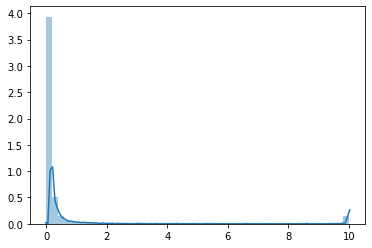

In [115]:
errors = np.vstack(train["reactivity_error"].values).flatten()
sns.distplot(errors.clip(-0.5, 10))

In [107]:
cc = np.random.gamma(1.2, 0.3, 10000)

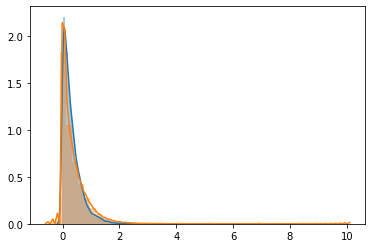

In [112]:
sns.distplot(cc-0.04)
sns.distplot(rss.clip(-0.5, 10))

In [126]:
np.median(cc-0.04), np.median(rss)

(0.21830739100629187, 0.21580000000000002)

In [136]:
ddd = rss + (np.random.gamma(1.2, 0.3, len(rss)) - 0.04)*errors

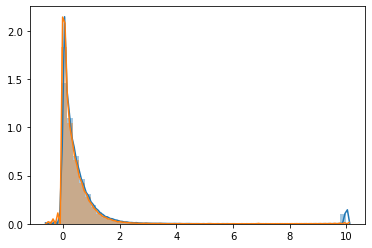

In [137]:
sns.distplot(ddd.clip(-0.5, 10))
sns.distplot(rss.clip(-0.5, 10))

In [138]:
rss[:10], ddd[:10]

(array([0.3297, 1.5693, 1.1227, 0.8686, 0.7217, 0.4384, 0.256 , 0.3364,
        0.2168, 0.3583]),
 array([0.32737048, 1.60529388, 1.22194872, 0.8732293 , 0.71662162,
        0.44086435, 0.31492832, 0.4331011 , 0.24363024, 0.35867173]))

In [1]:
import torch

In [6]:
a = torch.ones(10, 6, 5, 5)
b = torch.ones(10, 1, 5, 20)

In [11]:
c = torch.matmul(a, b)
c.shape

torch.Size([10, 6, 5, 20])

In [12]:
c.mean(dim=(1)).shape

torch.Size([10, 5, 20])

In [7]:
import pandas as pd
a = [
('2018-10-01',  2),
('2018-11-01',  6),
('2018-12-01',  2),
('2019-01-01',  4),
('2019-02-01',  8),
('2019-03-01',  2),
('2019-04-01',  6),
('2019-05-01',  2),
('2019-06-01', 9),
('2019-07-01',  6),
('2019-08-01',  7),
('2019-09-01',  5),
('2019-10-01',  7),
('2019-11-01',  7),
('2019-12-01',  4),
('2020-01-01',  2),
('2020-02-01',  14),
('2020-03-01',  10),
('2020-04-01',  13),
('2020-05-01',  4),
('2020-06-01',  3),
('2020-07-01',  4),
('2020-08-01',  2)
]

df = pd.DataFrame(a, columns=['month', 'purchase'])
df["month"] = pd.to_datetime(df["month"]).dt.month
df

,month,purchase
0,10,2
1,11,6
2,12,2
3,1,4
4,2,8
5,3,2
6,4,6
7,5,2
8,6,9
9,7,6


In [22]:
X = sm.add_constant(df['month'], prepend=True)

In [23]:
import statsmodels.api as sm
model = sm.RLM('purchase ~ month', M=sm.robust.norms.HuberT())

TypeError: __init__() missing 1 required positional argument: 'exog'

In [20]:
res = model.fit()

In [12]:
model.weights

array([0.96985508, 1.        , 0.78459347, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.91885611,
       1.        , 0.94323024, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [21]:
res.params, res.

purchase    0.764943
dtype: float64